# Data loading and preprocessing

In [1]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
# Define the path to the 'combined_images' directory
base_path = 'combined_images'

# Define the mapping of classes to numerical labels
folders = {
    'NonDemented': 0,
    'VeryMildDemented': 1,
    'MildDemented': 2,
    'ModerateDemented': 3
}

# Prepare lists to hold file paths and labels
file_paths = []
labels = []

# Iterate through each class directory and collect file paths and labels
for class_name, label in folders.items():
    class_path = os.path.join(base_path, class_name)
    for file in os.listdir(class_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            file_paths.append(os.path.join(class_path, file))
            labels.append(label)

# Create a DataFrame
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Downsample label 0 and label 1 to 10,000 images each
df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]
df_label_2 = df[df['label'] == 2]
df_label_3 = df[df['label'] == 3]

df_label_0_downsampled = resample(df_label_0, n_samples=10000, random_state=42, replace=False)
df_label_1_downsampled = resample(df_label_1, n_samples=10000, random_state=42, replace=False)

# Combine the downsampled and other labels into a new dataframe
df_downsampled = pd.concat([df_label_0_downsampled, df_label_1_downsampled, df_label_2, df_label_3])

# Verify the downsampling
print(df_downsampled['label'].value_counts())

label
0    10000
1    10000
2    10000
3    10000
Name: count, dtype: int64


In [3]:
# Split the dataset with stratification
train_df, temp_df = train_test_split(df_downsampled, test_size=0.2, stratify=df_downsampled['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)


In [4]:
# Define the dataset class
class SimpleMRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['file_path']
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['label'], dtype=torch.long)
        return image, label


In [5]:
transformations = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.3069,), (0.3185,))
])

In [6]:
# Create datasets and DataLoader objects
train_dataset = SimpleMRIDataset(train_df, transform=transformations)
val_dataset = SimpleMRIDataset(val_df, transform=transformations)
test_dataset = SimpleMRIDataset(test_df, transform=transformations)

In [7]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Print the number of images in each dataset
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the validation dataset: {len(val_dataset)}")
print(f"Number of images in the test dataset: {len(test_dataset)}")


Number of images in the training dataset: 32000
Number of images in the validation dataset: 4000
Number of images in the test dataset: 4000


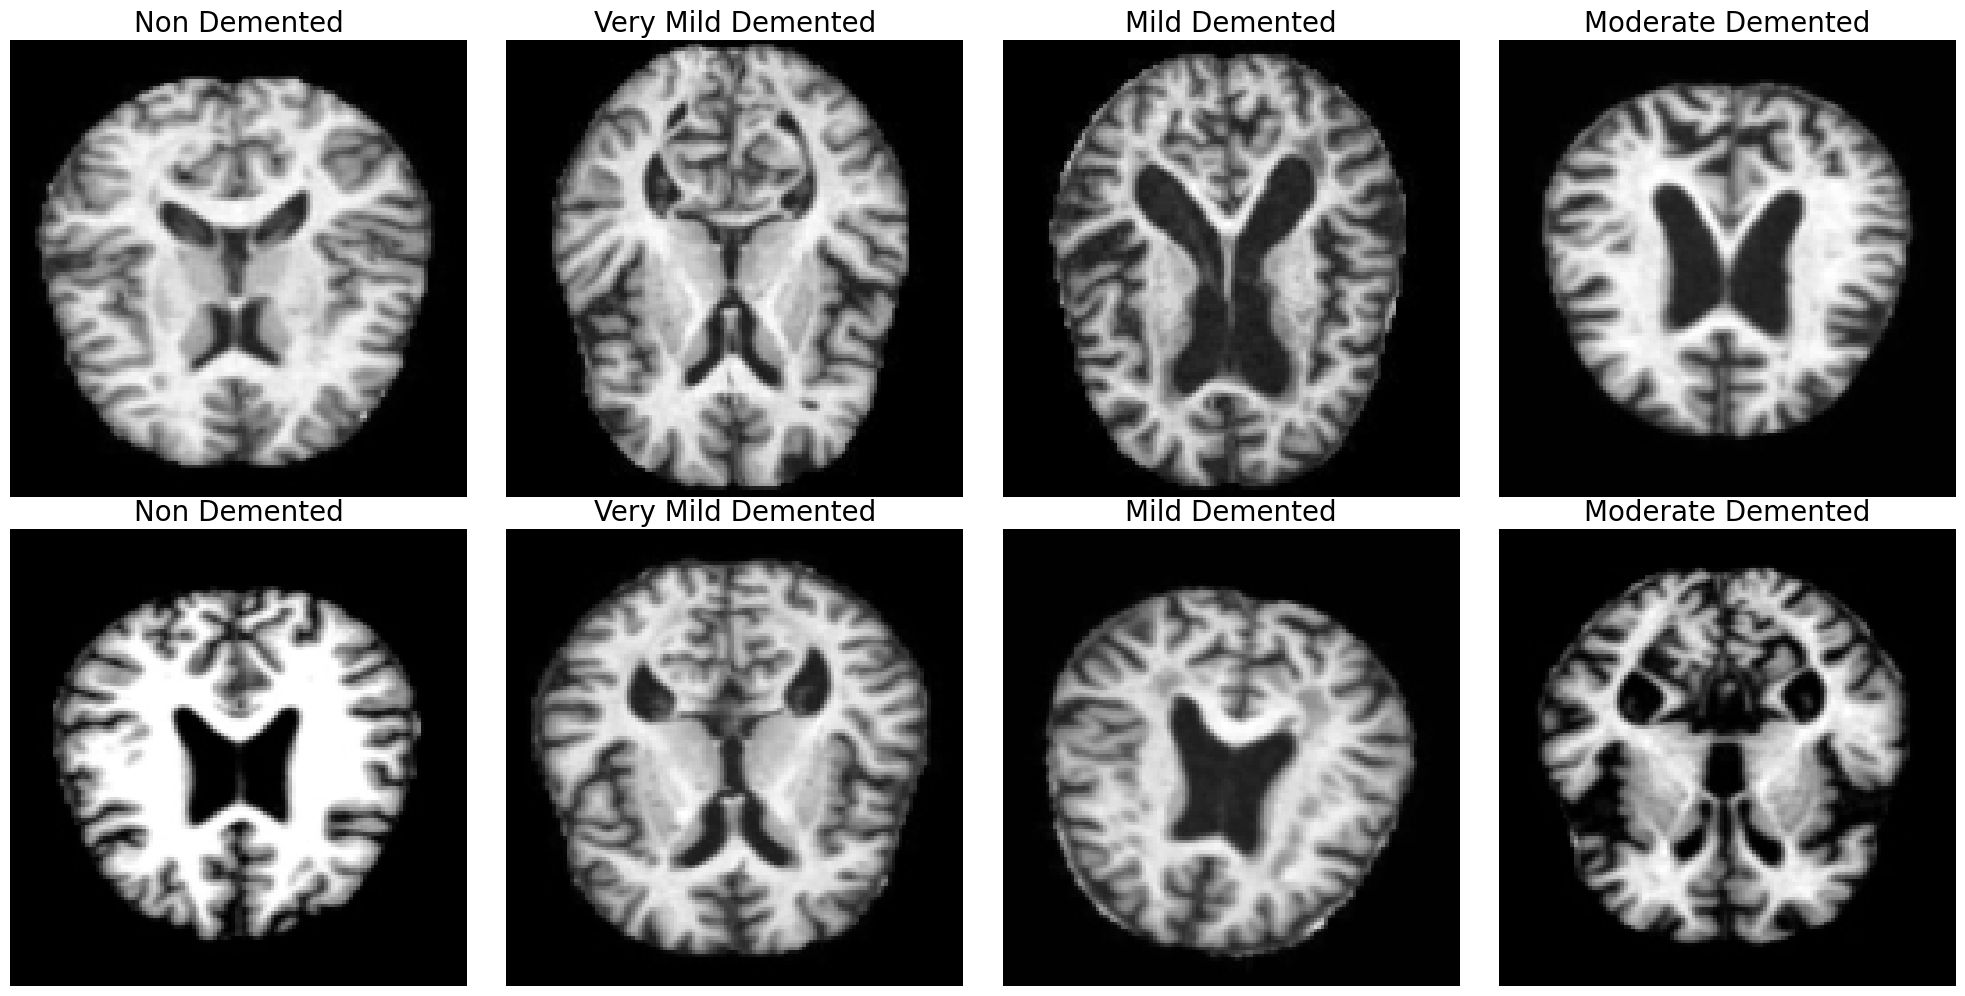

In [26]:
def show_images_from_each_class(loader):
    num_images_per_class = 2
    fig, axes = plt.subplots(num_images_per_class, 4, figsize=(20, 10))  # Adjust the number of subplots for horizontal layout
    class_titles = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
    images_found = {0: 0, 1: 0, 2: 0, 3: 0}  # Track the number of images found for each class
    
    for images, labels in loader:
        for i, (image, label) in enumerate(zip(images, labels)):
            label_idx = label.item()
            if images_found[label_idx] < num_images_per_class:  # Check if fewer than 2 images from this class have been displayed
                ax = axes[images_found[label_idx], label_idx]
                img = image.numpy()
                img = np.transpose(img, (1, 2, 0))
                # If your images are grayscale, ensure you're correctly handling single-channel visualization
                if img.shape[2] == 1:  # For grayscale images
                    ax.imshow(np.squeeze(img), cmap='gray')  # Remove the color channel
                else:
                    ax.imshow(img)
                label_text = class_titles[label_idx]
                ax.set_title(label_text, fontsize=20)  # Set label size to 20
                ax.axis('off')
                images_found[label_idx] += 1  # Increment the count for this class

            if all(count == num_images_per_class for count in images_found.values()):  # Break the loop if we've found 2 images from all classes
                break
        if all(count == num_images_per_class for count in images_found.values()):
            break

    plt.tight_layout()  # Use tight layout to minimize spacing
    plt.savefig('brains.png', dpi=300)  # Increase picture quality size while saving
    plt.show()

show_images_from_each_class(train_loader)


# Model

In [10]:
import time
import jax
import pickle
import os
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer
from quantum_transformers.quantum_layer import get_circuit

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [11]:
for d in jax.devices():
    print(d, d.device_kind)

TFRT_CPU_0 cpu


In [12]:
num_classes=4
patch_size=64
hidden_size=6
num_heads=3
num_transformer_blocks=6
mlp_hidden_size=5
num_epochs = 30
pos_embedding = 'learn'

In [13]:
# Initialize the model
model = VisionTransformer(
    num_classes=num_classes,
    patch_size=patch_size,
    hidden_size=hidden_size,
    num_heads=num_heads,
    num_transformer_blocks=num_transformer_blocks,
    mlp_hidden_size=mlp_hidden_size,
    quantum_attn_circuit=get_circuit(),
    quantum_mlp_circuit=get_circuit(),
    pos_embedding='learn'  # Positional embedding
)

In [14]:
# Saving model data

In [15]:
# Hyperparameters

hyperparameters = {
    'num_classes': num_classes,
    'num_epochs': num_epochs,
    'patch_size': patch_size,
    'hidden_size': hidden_size,
    'num_heads': num_heads,
    'num_transformer_blocks': num_transformer_blocks,
    'mlp_hidden_size': mlp_hidden_size,
    'pos_embedding': 'learn'
}

print(hyperparameters)

{'num_classes': 4, 'num_epochs': 30, 'patch_size': 64, 'hidden_size': 6, 'num_heads': 3, 'num_transformer_blocks': 6, 'mlp_hidden_size': 5, 'pos_embedding': 'learn'}


In [16]:
# Variables to track time and performance
epoch_times = []
total_start_time = time.time()
results = []

# Start training
start_time = time.time()

test_loss, test_auc, test_fpr, test_tpr, all_logits, all_labels = train_and_evaluate(
    model=model, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader, 
    test_dataloader=test_loader, 
    num_classes=num_classes,
    num_epochs=num_epochs
)

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds.')
    

{'params': {'Conv_0': {'bias': (6,), 'kernel': (64, 64, 1, 6)}, 'Dense_0': {'bias': (4,), 'kernel': (6, 4)}, 'LayerNorm_0': {'bias': (6,), 'scale': (6,)}, 'TransformerBlock_0': {'FeedForward_0': {'Dense_0': {'bias': (5,), 'kernel': (6, 5)}, 'Dense_1': {'bias': (6,), 'kernel': (5, 6)}, 'QuantumLayer_0': {'w': (1, 5)}}, 'LayerNorm_0': {'bias': (6,), 'scale': (6,)}, 'LayerNorm_1': {'bias': (6,), 'scale': (6,)}, 'MultiHeadSelfAttention_0': {'QuantumLayer_0': {'w': (1, 6)}, 'QuantumLayer_1': {'w': (1, 6)}, 'QuantumLayer_2': {'w': (1, 6)}, 'QuantumLayer_3': {'w': (1, 6)}}}, 'TransformerBlock_1': {'FeedForward_0': {'Dense_0': {'bias': (5,), 'kernel': (6, 5)}, 'Dense_1': {'bias': (6,), 'kernel': (5, 6)}, 'QuantumLayer_0': {'w': (1, 5)}}, 'LayerNorm_0': {'bias': (6,), 'scale': (6,)}, 'LayerNorm_1': {'bias': (6,), 'scale': (6,)}, 'MultiHeadSelfAttention_0': {'QuantumLayer_0': {'w': (1, 6)}, 'QuantumLayer_1': {'w': (1, 6)}, 'QuantumLayer_2': {'w': (1, 6)}, 'QuantumLayer_3': {'w': (1, 6)}}}, 'Tran

Epoch   1/30:   0%|          | 0/2000 [00:00<?, ?batch/s]2024-06-26 04:24:37.460465: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-06-26 04:27:29.204529: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m51.779595s

********************************
[Compiling module jit_train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch   1/30: 100%|██████████| 2000/2000 [09:06<00:00,  3.66batch/s, Loss = 1.1083, AUC = 77.7388%]


Epoch 1 completed. Validation Loss: 1.1083, Validation AUC: 77.7388%


Epoch   2/30: 100%|██████████| 2000/2000 [02:08<00:00, 15.59batch/s, Loss = 1.0309, AUC = 79.4101%]


Epoch 2 completed. Validation Loss: 1.0309, Validation AUC: 79.4101%


Epoch   3/30: 100%|██████████| 2000/2000 [02:22<00:00, 14.05batch/s, Loss = 0.9900, AUC = 81.1544%]


Epoch 3 completed. Validation Loss: 0.9900, Validation AUC: 81.1544%


Epoch   4/30: 100%|██████████| 2000/2000 [02:21<00:00, 14.15batch/s, Loss = 0.9408, AUC = 82.9586%]


Epoch 4 completed. Validation Loss: 0.9408, Validation AUC: 82.9586%


Epoch   5/30: 100%|██████████| 2000/2000 [02:22<00:00, 14.01batch/s, Loss = 0.9095, AUC = 83.8454%]


Epoch 5 completed. Validation Loss: 0.9095, Validation AUC: 83.8454%


Epoch   6/30: 100%|██████████| 2000/2000 [02:24<00:00, 13.83batch/s, Loss = 0.9273, AUC = 83.7265%]


Epoch 6 completed. Validation Loss: 0.9273, Validation AUC: 83.7265%


Epoch   7/30: 100%|██████████| 2000/2000 [02:30<00:00, 13.29batch/s, Loss = 0.8852, AUC = 84.7159%]


Epoch 7 completed. Validation Loss: 0.8852, Validation AUC: 84.7159%


Epoch   8/30: 100%|██████████| 2000/2000 [02:28<00:00, 13.47batch/s, Loss = 0.8791, AUC = 85.1880%]


Epoch 8 completed. Validation Loss: 0.8791, Validation AUC: 85.1880%


Epoch   9/30: 100%|██████████| 2000/2000 [02:31<00:00, 13.24batch/s, Loss = 0.8864, AUC = 84.9185%]


Epoch 9 completed. Validation Loss: 0.8864, Validation AUC: 84.9185%


Epoch  10/30: 100%|██████████| 2000/2000 [02:08<00:00, 15.58batch/s, Loss = 0.8758, AUC = 85.2582%]


Epoch 10 completed. Validation Loss: 0.8758, Validation AUC: 85.2582%


Epoch  11/30: 100%|██████████| 2000/2000 [02:03<00:00, 16.18batch/s, Loss = 0.8511, AUC = 85.8413%]


Epoch 11 completed. Validation Loss: 0.8511, Validation AUC: 85.8413%


Epoch  12/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.45batch/s, Loss = 0.8452, AUC = 86.1417%]


Epoch 12 completed. Validation Loss: 0.8452, Validation AUC: 86.1417%


Epoch  13/30: 100%|██████████| 2000/2000 [02:17<00:00, 14.51batch/s, Loss = 0.8720, AUC = 85.6556%]


Epoch 13 completed. Validation Loss: 0.8720, Validation AUC: 85.6556%


Epoch  14/30: 100%|██████████| 2000/2000 [02:19<00:00, 14.37batch/s, Loss = 0.8346, AUC = 86.5641%]


Epoch 14 completed. Validation Loss: 0.8346, Validation AUC: 86.5641%


Epoch  15/30: 100%|██████████| 2000/2000 [02:19<00:00, 14.35batch/s, Loss = 0.8624, AUC = 86.0649%]


Epoch 15 completed. Validation Loss: 0.8624, Validation AUC: 86.0649%


Epoch  16/30: 100%|██████████| 2000/2000 [02:17<00:00, 14.53batch/s, Loss = 0.8374, AUC = 86.5462%]


Epoch 16 completed. Validation Loss: 0.8374, Validation AUC: 86.5462%


Epoch  17/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.40batch/s, Loss = 0.8215, AUC = 86.8697%]


Epoch 17 completed. Validation Loss: 0.8215, Validation AUC: 86.8697%


Epoch  18/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.40batch/s, Loss = 0.8371, AUC = 86.6910%]


Epoch 18 completed. Validation Loss: 0.8371, Validation AUC: 86.6910%


Epoch  19/30: 100%|██████████| 2000/2000 [02:20<00:00, 14.27batch/s, Loss = 0.8230, AUC = 86.9615%]


Epoch 19 completed. Validation Loss: 0.8230, Validation AUC: 86.9615%


Epoch  20/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.48batch/s, Loss = 0.8313, AUC = 86.8443%]


Epoch 20 completed. Validation Loss: 0.8313, Validation AUC: 86.8443%


Epoch  21/30: 100%|██████████| 2000/2000 [02:17<00:00, 14.55batch/s, Loss = 0.8162, AUC = 87.1301%]


Epoch 21 completed. Validation Loss: 0.8162, Validation AUC: 87.1301%


Epoch  22/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.45batch/s, Loss = 0.8084, AUC = 87.3658%]


Epoch 22 completed. Validation Loss: 0.8084, Validation AUC: 87.3658%


Epoch  23/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.44batch/s, Loss = 0.8106, AUC = 87.4550%]


Epoch 23 completed. Validation Loss: 0.8106, Validation AUC: 87.4550%


Epoch  24/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.41batch/s, Loss = 0.7992, AUC = 87.6184%]


Epoch 24 completed. Validation Loss: 0.7992, Validation AUC: 87.6184%


Epoch  25/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.42batch/s, Loss = 0.8044, AUC = 87.5464%]


Epoch 25 completed. Validation Loss: 0.8044, Validation AUC: 87.5464%


Epoch  26/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.44batch/s, Loss = 0.8008, AUC = 87.5486%]


Epoch 26 completed. Validation Loss: 0.8008, Validation AUC: 87.5486%


Epoch  27/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.41batch/s, Loss = 0.8012, AUC = 87.6211%]


Epoch 27 completed. Validation Loss: 0.8012, Validation AUC: 87.6211%


Epoch  28/30: 100%|██████████| 2000/2000 [02:18<00:00, 14.47batch/s, Loss = 0.8001, AUC = 87.6129%]


Epoch 28 completed. Validation Loss: 0.8001, Validation AUC: 87.6129%


Epoch  29/30: 100%|██████████| 2000/2000 [02:01<00:00, 16.45batch/s, Loss = 0.7956, AUC = 87.7580%]


Epoch 29 completed. Validation Loss: 0.7956, Validation AUC: 87.7580%


Epoch  30/30: 100%|██████████| 2000/2000 [01:58<00:00, 16.87batch/s, Loss = 0.7951, AUC = 87.8557%]


Epoch 30 completed. Validation Loss: 0.7951, Validation AUC: 87.8557%
Total training time = 4543.99s, best validation AUC = 87.8557% at epoch 30
Total training time: 4550.91 seconds
Training Losses: []
Training AUCs: []
Validation Losses: [Array(1.1083207, dtype=float32), Array(1.03094, dtype=float32), Array(0.98996896, dtype=float32), Array(0.9407524, dtype=float32), Array(0.9094817, dtype=float32), Array(0.9273375, dtype=float32), Array(0.8851556, dtype=float32), Array(0.87907785, dtype=float32), Array(0.886427, dtype=float32), Array(0.87580216, dtype=float32), Array(0.851118, dtype=float32), Array(0.8451607, dtype=float32), Array(0.871989, dtype=float32), Array(0.83460194, dtype=float32), Array(0.8623692, dtype=float32), Array(0.8373955, dtype=float32), Array(0.8215089, dtype=float32), Array(0.83711654, dtype=float32), Array(0.8230138, dtype=float32), Array(0.83130944, dtype=float32), Array(0.81617665, dtype=float32), Array(0.808431, dtype=float32), Array(0.81064, dtype=float32), Ar

Testing: 100%|██████████| 250/250 [00:09<00:00, 25.84batch/s, Loss = 0.8320, AUC = 86.6679%]


Total training time: 4560.64 seconds.


# Metrics

In [17]:
from sklearn.metrics import classification_report

# Assuming binary classification with logits as probabilities
#predicted_labels = (all_logits > 0.5).astype(int)

# For binary classification with raw scores or multi-class classification
predicted_labels = np.argmax(all_logits, axis=1)

true_labels = all_labels

print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.61      0.61      0.61      1000
           1       0.51      0.48      0.49      1000
           2       0.64      0.62      0.63      1000
           3       0.79      0.86      0.82      1000

    accuracy                           0.64      4000
   macro avg       0.64      0.64      0.64      4000
weighted avg       0.64      0.64      0.64      4000



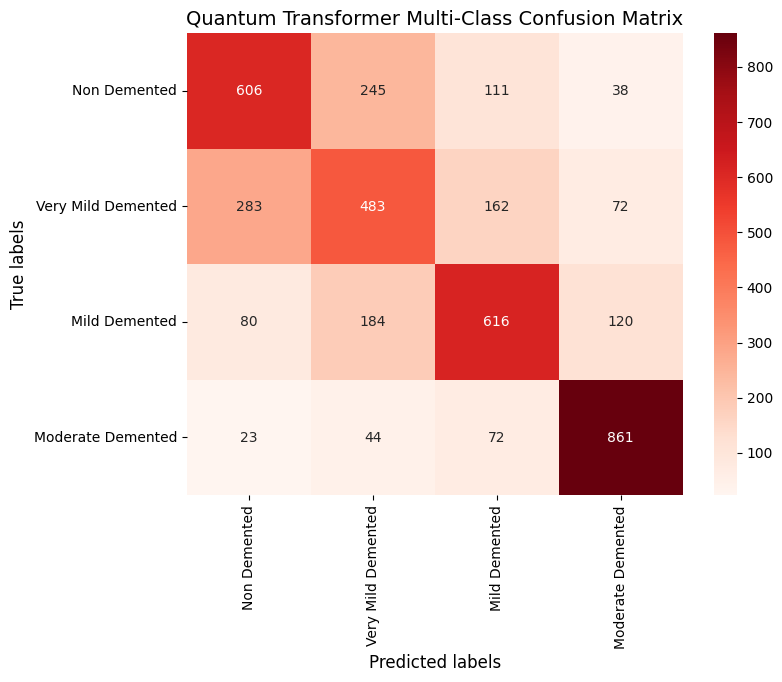

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Folder names mapping
folders = {
    'Non Demented': 0,
    'Very Mild Demented': 1,
    'Mild Demented': 2,
    'Moderate Demented': 3
}

# Assuming you already have predicted_labels and true_labels from your previous code
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Reverse the dictionary to get the labels
labels = {v: k for k, v in folders.items()}

fig, ax = plt.subplots(figsize=(8, 6))  # Set the size of the figure

# Create a heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', ax=ax,
            xticklabels=[labels[i] for i in range(len(labels))],
            yticklabels=[labels[i] for i in range(len(labels))])

# Labels, title, and ticks
label_font = {'size':'12'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Quantum Transformer Multi-Class Confusion Matrix', fontdict={'size':14})  # Adjust to fit
ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit

# Save the figure
#plt.savefig('confusion_matrix.png')
plt.show()


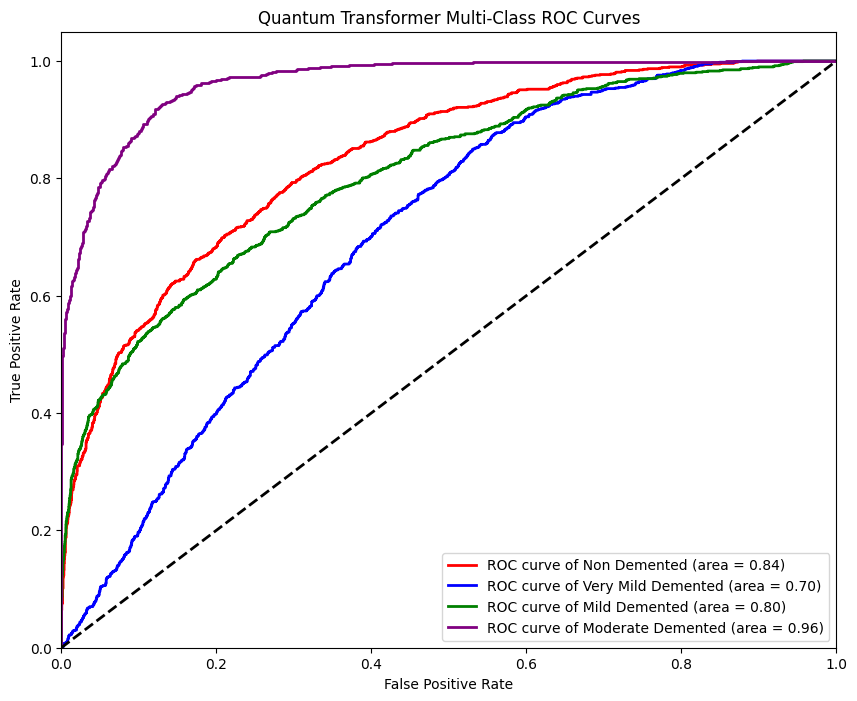

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Assuming true_labels and all_logits are defined
# Folder names mapping
folders = {
    'Non Demented': 0,
    'Very Mild Demented': 1,
    'Mild Demented': 2,
    'Moderate Demented': 3
}

# Inverse mapping for plotting
folder_names = {v: k for k, v in folders.items()}

# Binarize the output labels for multi-class
y = label_binarize(true_labels, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], all_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['red', 'blue', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'.format(folder_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Quantum Transformer Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.show()


# Normalization calculation

In [20]:
# import torch

# def compute_mean_std(loader):
#     # Variables to store the sum, squared sum, and the number of samples
#     sum = 0.0
#     squared_sum = 0.0
#     num_samples = 0.0
    
#     for images, _ in loader:
        
#         # Accumulate the number of samples
#         num_samples += images.size(0)
        
#         # Flatten the images to compute the sum and squared sum across all pixels
#         images = images.view(images.size(0), images.size(1), -1)
#         sum += images.mean(2).sum(0)
#         squared_sum += (images ** 2).mean(2).sum(0)
    
#     # Compute the mean and standard deviation
#     mean = sum / num_samples
#     std = (squared_sum / num_samples - mean ** 2) ** 0.5
    
#     return mean, std

# # Assuming the train_loader is defined and loaded with your dataset
# mean, std = compute_mean_std(train_loader)

# print(f"Mean: {mean}")
# print(f"Std: {std}")


# Adding images

In [21]:
# import os
# import pandas as pd
# from PIL import Image
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader
# import torch
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.utils import resample

# # Define the path to the 'combined_images' directory
# base_path = 'combined_images'

# # Define the mapping of classes to numerical labels
# folders = {
#     'NonDemented': 0,
#     'VeryMildDemented': 1,
#     'MildDemented': 2,
#     'ModerateDemented': 3
# }

# # Prepare lists to hold file paths and labels
# file_paths = []
# labels = []

# # Iterate through each class directory and collect file paths and labels
# for class_name, label in folders.items():
#     class_path = os.path.join(base_path, class_name)
#     for file in os.listdir(class_path):
#         if file.endswith('.jpg') or file.endswith('.png'):
#             file_paths.append(os.path.join(class_path, file))
#             labels.append(label)

# # Create a DataFrame
# df = pd.DataFrame({
#     'file_path': file_paths,
#     'label': labels
# })

# # Separate DataFrames for labels 2 and 3
# df_label_2 = df[df['label'] == 2]
# df_label_3 = df[df['label'] == 3]

# # Define the transformation/augmentation
# transformations = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(5),
#     # transforms.Resize(64),
#     # transforms.CenterCrop(64),
#     transforms.ToTensor(),
#     # transforms.Normalize((0.3092,), (0.3144,))
# ])

# # Function to save augmented images
# def augment_and_save(df, label_name, current_count, target_count=10000):
#     output_folder = os.path.join(base_path, f'{label_name}')
#     os.makedirs(output_folder, exist_ok=True)

#     added_count = 0
#     while current_count + added_count < target_count:
#         for index, row in df.iterrows():
#             if current_count + added_count >= target_count:
#                 break
#             img_path = row['file_path']
#             image = Image.open(img_path).convert('L')  # Convert image to grayscale
#             augmented_image = transformations(image)
#             augmented_image = augmented_image.mul(255).byte().numpy().transpose((1, 2, 0))

#             augmented_image_pil = Image.fromarray(augmented_image.squeeze(), 'L')
#             save_path = os.path.join(output_folder, f'aug_{current_count + added_count}_{os.path.basename(img_path)}')
#             augmented_image_pil.save(save_path)
#             added_count += 1

# # Calculate the number of images to augment for each label
# current_label_2_count = len(df_label_2)
# current_label_3_count = len(df_label_3)

# augment_and_save(df_label_2, 'MildDemented', current_label_2_count)
# augment_and_save(df_label_3, 'ModerateDemented', current_label_3_count)

# print(f"Augmented images for labels 2 and 3 have been saved in their respective folders.")


In [25]:
# def count_samples(loader):
#     sample_count = 0
#     for images, labels in loader:
#         sample_count += len(images)
#     return sample_count

# total_samples = count_samples(train_loader)
# print(f"Total number of samples: {total_samples}")


Total number of samples: 32000
